In [1]:
import pandas as pd

In [25]:
import warnings

warnings.filterwarnings('ignore')

In [10]:
train = pd.read_csv(r'images\metadata\train_metadata.csv')
val = pd.read_csv(r'images\metadata\val_metadata.csv')
valb = pd.read_csv(r'images\metadata\valb_metadata.csv')

In [11]:
train['Image_File'] = train.iloc[:, 2].str.lstrip('/kaggle/input/isic-2019jpgresized224x224imagechallenge')
val['Image_File'] = val.iloc[:, 2].str.lstrip('/kaggle/input/isic-2019jpgresized224x224imagechallenge')
valb['Image_File'] = valb.iloc[:, 2].str.lstrip('/kaggle/input/isic-2019jpgresized224x224imagechallenge')


In [13]:
train.to_csv(r'images\metadata\train_metadata_updated.csv', index=False)
val.to_csv(r'images\metadata\val_metadata_updated.csv', index=False)
valb.to_csv(r'images\metadata\valb_metadata_updated.csv', index=False)

In [22]:
train_df = pd.read_csv(r'images\metadata\train_metadata_updated.csv')
val_df = pd.read_csv(r'images\metadata\val_metadata_updated.csv')

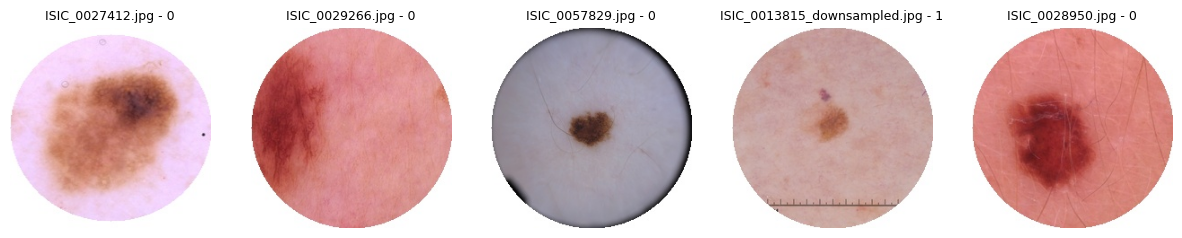

In [17]:
# let;s check to see how these images are stored
import os
from pathlib import Path
import random

import cv2
from matplotlib import pyplot as plt

def load_images_from_directory(directory, num_images=5):
    """
    Load a specified number of random images from a directory.
    """
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    selected_files = random.sample(image_files, num_images)
    images = []
    
    for file_name in selected_files:
        file_path = os.path.join(directory, file_name)
        image = cv2.imread(file_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
        images.append((file_name, image_rgb))
    
    return images

def display_images(df, images):
    """
    Display a list of images with their filenames using matplotlib.
    """
    num_images = len(images)
    plt.figure(figsize=(15, 10))
    
    for i, (file_name, image) in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        
        isic_id = file_name.split('.')[0]
        label = df[df['isic_id'] == isic_id]['Label'].values[0]
        plt.title(Path(file_name).name + " - " + str(label), fontsize=9)
        plt.axis('off')
    
    plt.show()

directory = 'images/train_images'
images = load_images_from_directory(directory, num_images=5)
display_images(train_df, images)

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, directory, transform=None):
        self.dataframe = dataframe
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 2]
        img_path = os.path.join(self.directory, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, 3]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = ImageDataset(dataframe=train_df, directory=directory, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))

model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        labels = labels.float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete")

Epoch 1/2: 100%|██████████| 240/240 [07:48<00:00,  1.95s/it]


Epoch [1/2], Loss: 0.6157


Epoch 2/2: 100%|██████████| 240/240 [06:56<00:00,  1.73s/it]

Epoch [2/2], Loss: 0.5593
Training complete


In [29]:
valb_df = pd.read_csv(r'images\metadata\valb_metadata_updated.csv')

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Create validation dataset and dataloader
val_directory = 'images/valb_images'
val_dataset = ImageDataset(dataframe=valb_df, directory=val_directory, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    actual = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            outputs = model(images)
            predicted = (outputs >= 0.5).float()
            predictions.extend(predicted.cpu().numpy())
            actual.extend(labels.cpu().numpy())
    
    return predictions, actual

# Calculate metrics

# Get predictions
predictions, actual = evaluate_model(model, val_loader)

# Calculate metrics
accuracy = accuracy_score(actual, predictions)
precision = precision_score(actual, predictions)
recall = recall_score(actual, predictions)
f1 = f1_score(actual, predictions)
auc = roc_auc_score(actual, predictions)

# Print results
print("\nModel Performance Metrics on Validation Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

Evaluating: 100%|██████████| 37/37 [00:28<00:00,  1.28it/s]


Model Performance Metrics on Validation Set:
Accuracy: 0.6550
Precision: 0.6972
Recall: 0.5479
F1 Score: 0.6136
AUC-ROC: 0.6550
